In [9]:

import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
from scipy.integrate import simps

scaler_filename = 'scaler2.pkl'

In [10]:
def MSE_calc(x, y):
    return np.mean((x - y)**2)

In [25]:
def prepData(path, cat = True):
    data = pd.read_csv(path, sep=',', skipinitialspace=True)
    
    data_cat = data[['C_ 1', 'C_ 2', 'C_ 3', 'C_ 4', 'C_ 5']]
    
    scaler_filename = 'scaler2.pkl'
    
    scaler = StandardScaler()
    
    joblib.dump(scaler, scaler_filename)
        
    data_encoded = pd.get_dummies(data_cat).astype(int)

    data_norm = data.copy()
    data_norm.iloc[:, :96] = scaler.fit_transform(data_norm.iloc[:, :96])
    
    if cat == True:
        data_tot = pd.concat([data_norm.iloc[:,:96],data_encoded], axis=1)
    else:
        data_tot = data_norm.iloc[:, :96]
    
    return data_tot

In [ ]:
"""
### Mean imputation
data_mean_imputed = data_cont.copy(deep=True)

# Impute the missing values with the mean of the column
for col in data_cont.columns:
    data_mean_imputed[col] = data_cont[col].fillna(data_cont[col].mean())

MSE_out = []
for k in range(1, 10):
    # Perform KNN imputation
    print(k)
    knn_imputer = KNNImputer(n_neighbors=k, weights='distance') 
    data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_cont), columns=data_cont.columns)
    
    MSE_total = 0
    for col in data_cont.columns:
        a = data_mean_imputed[col].to_numpy()
        b = data_imputed[col].to_numpy()

        MSE_total += MSE_calc(a, b)
    
    MSE_out.append(MSE_total)
        
print(MSE_out)
print(np.argmin(MSE_out) + 1)
best_k = np.argmin(MSE_out)
"""

In [30]:
data_imputed = pd.read_csv("data_done.csv")
data_imputed.head()

,y,x_ 1,x_ 2,x_ 3,x_ 4,x_ 5,x_ 6,x_ 7,x_ 8,x_ 9,...,C_ 4_G,C_ 4_H,C_ 4_I,C_ 4_J,C_ 4_K,C_ 5_G,C_ 5_H,C_ 5_I,C_ 5_J,C_ 5_K
0,90.685036,23.983338,12.288310,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,60.844445,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,17.516819,-2.442164,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,18.062345,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-8.139839,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-4.994792,25.400286,12.182442,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,14.893863,-7.341165,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [46]:
### Random forest ###

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
clf = RandomForestRegressor(bootstrap=True, oob_score=True, criterion = "friedman_mse", random_state=42)

X = data_imputed.iloc[:, 1:]
y = data_imputed.iloc[:, 0]

n_estimators = range(10,12)  # Increase the number of trees
max_depth = range(4,10)
max_features = range(20,50,10)

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features
}

clf = RandomForestRegressor(bootstrap=True, oob_score=True, criterion = "friedman_mse", random_state=42)

rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

rf_grid.fit(X, y)

#Save the results in a dataframe to disk
df = pd.DataFrame(rf_grid.cv_results_)
df.to_csv('CrossValidationResultsRandomForest.csv')

print(rf_grid.best_estimator_)
#RandomForestRegressor(criterion='friedman_mse', max_depth=7, max_features=20, n_estimators=117, oob_score=True, random_state=42)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomForestRegressor(criterion='friedman_mse', max_depth=6, max_features=20,
                      n_estimators=10, oob_score=True, random_state=42)


In [47]:
print(X.shape)

(100, 116)


In [48]:
### Måske kig ind i hvor optimal GridSearchCV er ###
"""

df_100_estimators = df[df['param_n_estimators']==100]

fig, ax = plt.subplots(figsize=(15,15))

_ = sns.lineplot(data=df_100_estimators, x='param_max_depth', y='mean_test_score', hue='param_max_features', ax=ax)
ax.set_xlabel('Maximum tree depth')
ax.set_ylabel('Mean test accuracy')
"""

"\n\ndf_100_estimators = df[df['param_n_estimators']==100]\n\nfig, ax = plt.subplots(figsize=(15,15))\n\n_ = sns.lineplot(data=df_100_estimators, x='param_max_depth', y='mean_test_score', hue='param_max_features', ax=ax)\nax.set_xlabel('Maximum tree depth')\nax.set_ylabel('Mean test accuracy')\n"

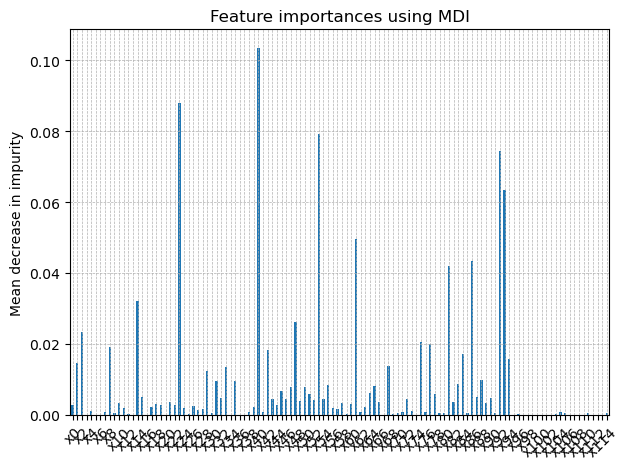

In [49]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import pandas as pd
importances = rf_grid.best_estimator_.feature_importances_

#std = np.std([tree.feature_importances_ for tree in rf_grid.best_estimator_.estimators_], axis=0)
feature_names = [f"x{i}" for i in range(X.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()

#forest_importances.plot.bar(yerr=std, ax=ax)
forest_importances.plot.bar(ax=ax)
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    if i % 2 == 1:
        label.set_visible(False)

plt.xticks(rotation=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

fig.tight_layout()

In [51]:
y_pred = rf_grid.best_estimator_.predict(X)
RMSE_RF = math.sqrt(mean_squared_error(y, y_pred))
print(RMSE_RF)

20.515081553032466


In [69]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import math

regr = AdaBoostRegressor(random_state=0, n_estimators=100)

n_estimators = range(10, 100, 2)  # Increase the number of trees
learning_rate = np.linspace(0.001, 1, 10)

param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate, 
    'loss' : ["square"]
}

ada_grid = GridSearchCV(estimator = regr, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

ada_grid.fit(X, y)
print(ada_grid.best_estimator_)
y_pred = ada_grid.best_estimator_.predict(X) 
RMSE_AB = math.sqrt(mean_squared_error(y, y_pred))
print(RMSE_AB)


Fitting 5 folds for each of 450 candidates, totalling 2250 fits
AdaBoostRegressor(learning_rate=0.445, loss='square', n_estimators=72,
                  random_state=0)
14.388554758491715


In [53]:
print(y_pred)
print(len(y_pred))

[  84.9052395    55.39871321    2.765939      0.24886667   -3.38659229
  -58.96332012  -33.56941255   35.29936521  -37.01433013   45.80514038
  -52.848578    -29.4999734   -47.809548    -28.01908486   58.06515883
   59.15961429   33.49125244    3.31816878  -57.940619      1.06205021
   24.20050746 -178.046246    -49.95781683   43.123915   -108.89660743
   25.87482283    7.05354724  -26.53625865   -0.7764607     0.806013
    1.59490148  -40.12669878  -27.70321168   46.17639333    3.55994441
  -29.0017978     2.765939    -10.58339593  -49.95781683   12.30617496
  -10.1759647    43.123915      5.29538452    3.55994441 -113.73027805
   16.58735492  -59.96320733  -12.19980729   -3.86079929    1.31001604
  -37.0006772    -6.49997038    2.79282023   93.00836567  -60.29636258
  -58.74852127   -3.5996485   -48.4869754  -118.3544904  -104.89773353
    9.07442813    0.30343369   14.82876656   66.96025204    1.31001604
   37.75863707   48.42332043   -3.38659229   19.71682456   33.53986552
   10.21

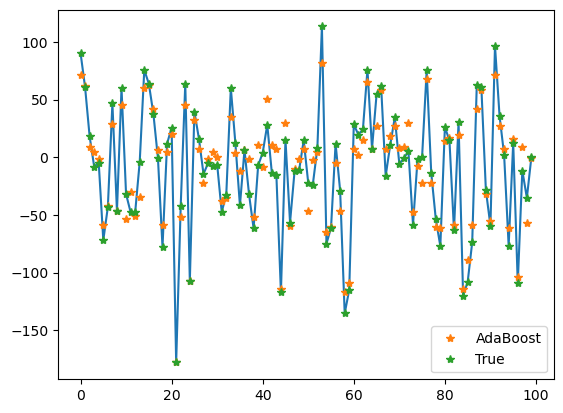

In [64]:
plt.plot(range(data_imputed.shape[0]), data_imputed['y'])
plt.plot(y.index, y_pred, '*', label = "AdaBoost")
plt.plot(y.index, data_imputed['y'].iloc[y.index], '*', label = "True")
plt.legend()
plt.show()